#ENAS Discovered Network

##Importing All required weapon

In [1]:
from keras import backend as k
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)
from keras.models import Model, Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


##Loading CIFAR-10 Dataset into Train and Test features, labels.

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols = train_features.shape
num_test, img_channels, img_rows, img_cols = test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


##Visualizing Datasets values with divided into 10 classes

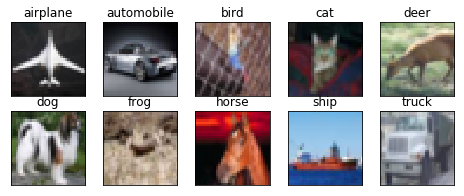

In [3]:
class_names = ['airplane', 'automobile','bird','cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
  ax = fig.add_subplot(2, 5, 1 + i, xticks =[], yticks=[])
  idx = np.where(train_labels[:]==i)[0]
  feature_idx = train_features[idx,::]
  img_num = np.random.randint(feature_idx.shape[0])
  im = feature_idx[img_num]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

##Reusable method for create Model  Plot with consist of Accuracy, Epoch, Loss of Model

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

##Reusable function for Accuracy prediction 

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

##Pre-proccessing of Test and Train features of data

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

#convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Import Tensorflow package for resizing of layers with moderate space_to_depth changes

In [0]:
import tensorflow as tf
# x is input layer 
#Space_to_depth works as divide block to four equal size and concate in sequential order back to back
#Example: 32x32x32 to convert space to depth be like  16x16x128
def space_to_depth_x2(x):
  return tf.space_to_depth(x, block_size=2)

## ENAS (Efficient Neural Architecture Search) Architecture: Image Classification
![alt text](https://github.com/Mayank01/EVA/blob/master/Session7/Assignment/ENAS_ntw7B.png?raw=true)

                                                               

##Model Connections:
![link text](https://github.com/Mayank01/EVA/blob/master/Session7/Assignment/ENAS_7B.PNG?raw=true)

##Define Model Architecture

In [11]:
from keras.layers import Lambda, concatenate, Conv2D, Convolution2D, Input, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D

#Define the Model
Input_Shape = Input(shape=(32, 32, 3))

############ Start ## Division-A #################
### Layer-1
#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer1 = SeparableConv2D(32, 5, padding='same', name='SepConv_01')(Input_Shape)   #Input size 32x32
layer1 = BatchNormalization(name='BN_01')(layer1)
layer1 = Activation('relu', name='relu_01')(layer1)

#Skip Connection Layer-1
skip_connect_l1 = layer1              #Input to layer 4,6,8,10,MaxPool-1,MaxPool-2

### Layer-2
#Normal Convolution
layer2 = Conv2D(32, (5, 5), padding='same', name='Conv_02')(layer1)              #Input size 32x32
layer2 = BatchNormalization(name='BN_02')(layer2)
layer2 = Activation('relu', name='relu_02')(layer2)

#Skip Connection Layer-2
skip_connect_l2 = layer2              #Input to layer 10,11

### Layer-3
#Normal Convolution
layer3 = Conv2D(32, (5, 5), padding='same', name='Conv_03')(layer2)              #Input size 32x32
layer3 = BatchNormalization(name='BN_03')(layer3)
layer3 = Activation('relu', name='relu_03')(layer3)

#Skip Connection Layer-3
skip_connect_l3 = layer3              #Input to layer 7,8,11,12

#Add Skip Layer-1 to Layer-4 
#Concatation of Layers (1, Layer-3) for Layer-4
layer3 = concatenate ([layer3, skip_connect_l1], axis=-1)

### Layer-4
#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer4 = SeparableConv2D(32, 5, padding='same', name='SepConv_04')(layer3)       #Input size 32x32
layer4 = BatchNormalization(name='BN_04')(layer4)
layer4 = Activation('relu', name='relu_04')(layer4)

#Skip Connection Layer-4
skip_connect_l4 = layer4              #Input to layer 6,7,8,10,12,MP2,Softmax

#Add Skip Layer-1 to Maxpool-1 
layer4 = concatenate ([layer4, skip_connect_l1],axis=-1)

#MaxPooling Layer-1
maxpoolLayer1 = MaxPooling2D(pool_size=(2,2))(layer4)
maxpoolLayer1 = Lambda(space_to_depth_x2)(maxpoolLayer1)

maxpoolLayer1 = Conv2D(32, (1, 1), padding='same', name='maxpoolLayer1')(layer4)
############ End ## Division-A #################

############ Start ## Division-B #################
### Layer-5
#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer5 = SeparableConv2D(32, 3, padding='same', name='SepConv_05')(maxpoolLayer1)    #Input size 16x16
layer5 = BatchNormalization(name='BN_05')(layer5)
layer5 = Activation('relu', name='relu_05')(layer5)

layer5 = Lambda(space_to_depth_x2)(layer5)
layer5 = Conv2D(32, (1, 1), padding='same', name='layer5')(layer5)

#Skip Connection Layer-5
skip_connect_l5 = layer5               #Input to layer 7,8,11,12,MP2

#Add Skip Layer-1 to Layer-6 
skip_con1To6 = Lambda(space_to_depth_x2)(skip_connect_l1)
#Add Skip Layer-4 to Layer-6 
skip_con4To6 = Lambda(space_to_depth_x2)(skip_connect_l4)

#Concatation of Layers (1, 4 and Layer-5) for Layer-6
layer5 = concatenate ([layer5, skip_con1To6, skip_con4To6], axis=-1)


### Layer-6
#Normal Convolution
layer6 = Conv2D(32, (5, 5), padding='same', name='Conv_06')(layer5)                 #Input size 16x16
layer6 = BatchNormalization(name='BN_06')(layer6)
layer6 = Activation('relu', name='relu_06')(layer6)

#Skip Connection Layer-6
skip_connect_l6 = layer6                #Input to layer 8,9

# add Skip Layer 3 to 7 
skip_con3To7 = Lambda(space_to_depth_x2)(skip_connect_l3)
skip_con3To7 = Conv2D(32, (1, 1), padding='same', name='skip_con3To7_1x1')(skip_con3To7)
# add Skip Layer 4 to 7 
skip_con4To7 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4To7 = Conv2D(32, (1, 1), padding='same', name='skip_con4To7_1x1')(skip_con4To7)
# add Skip Layer 5 to 7 
skip_con5To7 = skip_connect_l5
skip_con5To7 = Conv2D(32, (1, 1), padding='same', name='skip_con5To7_1x1')(skip_con5To7)

#Concatation of Layers (3, 4, 5, and Layer-6) for Layer-7
layer6 = concatenate ([layer6, skip_con3To7, skip_con4To7, skip_con5To7], axis=-1)
layer6 = Conv2D(32, (1, 1), padding='same', name='layer6_1x1')(layer6)
### Layer-7
#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer7 = SeparableConv2D(32, 3, padding='same', name='SepConv_07')(layer6)         #Input size 16x16
layer7 = BatchNormalization(name='BN_07')(layer7)
layer7 = Activation('relu', name='relu_07')(layer7)

#Skip Connection Layer-7
skip_connect_l7 = layer7                #Input to layer 10,12,MP2,Softmax

#Concatation of Layers (1, 3, 4, 5, 6 and Layer 7) for Layer-8
layer7 = concatenate ([layer7, skip_con1To6, skip_con3To7, skip_con4To7, skip_connect_l5, skip_connect_l6])

### Layer-8
#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer8 = SeparableConv2D(32, 5, padding='same', name='SepConv_08')(layer7)         #Input Image 16x16
layer8 = BatchNormalization(name='BN_08')(layer8)
layer8 = Activation('relu', name='relu_08')(layer8)

# add Skip Layer 1 to MaxP -2 
skip_con1ToMP2 = Lambda(space_to_depth_x2)(skip_connect_l1)
skip_con1ToMP2 = Conv2D(32, (1, 1), padding='same', name='skip_con1ToMP2_1x1')(skip_con1ToMP2)
# add Skip Layer 4 to MP2 
skip_con4ToMP2 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4ToMP2 = Conv2D(32, (1, 1), padding='same', name='skip_con4ToMP2_1x1')(skip_con4ToMP2)
# add Skip Layer 5 to MP2 
skip_con5ToMP2 = (skip_connect_l5)
skip_con5ToMP2 = Conv2D(32, (1, 1), padding='same', name='skip_con5ToMP2_1x1')(skip_con5ToMP2)

# add Skip Layer 7 to MP2 
skip_con7ToMP2 = (skip_connect_l7)

#Concatation of Layers (1, 4 , 5 ,7 and Layer 8) for MaxPool-2
layer8 = concatenate ([layer8, skip_con1ToMP2, skip_con4ToMP2, skip_con5ToMP2, skip_con7ToMP2])  #Size 16x16x32
layer8 = Conv2D(128, (1, 1), padding='same', name='layer8_1x1')(layer8)

#MaxPooling Layer-2
maxpoolLayer2 = MaxPooling2D(pool_size=(2,2))(layer8)
                         
#Add Skip Layer-6 to Layer-9 
skip_con6To9 = Lambda(space_to_depth_x2)(skip_connect_l6)

#Concatenation of (Maxpool2 + Layer 6)
maxpoolLayer2 = concatenate ([maxpoolLayer2, skip_con6To9])       # size 8x8x128

############ End ## Division-B #################

############ Start ## Division-C #################

### Layer-9
#Normal Convolution
layer9 = Conv2D(32, (5, 5), padding='same', name='Conv_09')(maxpoolLayer2)   #Input 8x8
layer9 = BatchNormalization(name='BN_09')(layer9)
layer9 = Activation('relu', name='relu_09')(layer9)

#Skip Connection Layer-9
skip_connect_l9 = layer9                 #Input to layer 10,11

# add Skip Layer 1 to 10 
skip_con1To10 = Lambda(space_to_depth_x2)(skip_connect_l1)
skip_con1To10 = Lambda(space_to_depth_x2)(skip_con1To10)
skip_con1To10 = Conv2D(32, (1, 1), padding='same', name='skip_con1To10_1x1')(skip_con1To10)

# add Skip Layer 2 to 10
skip_con2To10 = Lambda(space_to_depth_x2)(skip_connect_l2)
skip_con2To10 = Lambda(space_to_depth_x2)(skip_con2To10)
skip_con2To10 = Conv2D(32, (1, 1), padding='same', name='skip_con2To10_1x1')(skip_con2To10)

# add Skip Layer 4 to 10 
skip_con4To10 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4To10 = Lambda(space_to_depth_x2)(skip_con4To10)
skip_con4To10 = Conv2D(32, (1, 1), padding='same', name='skip_con4To10_1x1')(skip_con4To10)

# add Skip Layer 7 to 10 
skip_con7To10 = Lambda(space_to_depth_x2)(skip_connect_l5)

#skip_con5ToMP2 = (skip_connect_l5)
skip_con7To10 = Conv2D(32, (1, 1), padding='same', name='skip_con7To10_1x1')(skip_con7To10)

#Concatation of Layers (1, 2, 4, 7 and Layer-9) for Layer-10
layer9 = concatenate ([layer9, skip_con1To10, skip_con2To10, skip_con4To10, skip_con7To10])   #Size 8x8x32

### Layer-10
#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer10 = SeparableConv2D(32, 5, padding='same', name='SepConv_10')(layer9)  #Input 8x8
layer10 = BatchNormalization(name='BN_10')(layer10)
layer10 = Activation('relu', name='relu_10')(layer10)

#Skip Connection Layer-10
skip_connect_l10 = layer10               #Input to layer 12,Softmax

# add Skip Layer 2 to 11 
skip_con2To11 = Lambda(space_to_depth_x2)(skip_connect_l2)
skip_con2To11 = Lambda(space_to_depth_x2)(skip_con2To11)
skip_con2To11 = Conv2D(32, (1, 1), padding='same', name='skip_con2To11_1x1')(skip_con2To11)

# add Skip Layer 3 to 11 
skip_con3To11 = Lambda(space_to_depth_x2)(skip_connect_l3)
skip_con3To11 = Lambda(space_to_depth_x2)(skip_con3To11)
skip_con3To11 = Conv2D(32, (1, 1), padding='same', name='skip_con3To11_1x1')(skip_con3To11)

# add Skip Layer 5 to 11
skip_con5To11 = Lambda(space_to_depth_x2)(skip_connect_l5)
skip_con5To11 = Conv2D(32, (1, 1), padding='same', name='skip_con5To11_1x1')(skip_con5To11)

# add Skip Layer 9 to 11 
skip_con9To11 = (skip_connect_l9)
#Concatation of Layers (2, 3, 5, 9 and Layer-10) for Layer-11
layer10 = concatenate ([layer10, skip_con2To11, skip_con3To11, skip_con5To11, skip_con9To11]) #size 8x8x32

### Layer-11
#Normal Convolution
layer11 = Conv2D(32, (3, 3), padding='same', name='conv_11')(layer10)  #Input 8x8
layer11 = BatchNormalization(name='BN_11')(layer11)
layer11 = Activation('relu', name='relu_11')(layer11)

# add Skip Layer 3 to 12 
skip_con3To12 = Lambda(space_to_depth_x2)(skip_connect_l3)
skip_con3To12 = Lambda(space_to_depth_x2)(skip_con3To12)
skip_con3To12 = Conv2D(32, (1, 1), padding='same', name='skip_con3To12_1x1')(skip_con3To12)

# add Skip Layer 4 to 12 
skip_con4To12 = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4To12 = Lambda(space_to_depth_x2)(skip_con4To12)
skip_con4To12 = Conv2D(32, (1, 1), padding='same', name='skip_con4To12_1x1')(skip_con4To12)

# add Skip Layer 5 to 12 
skip_con5To12 = Lambda(space_to_depth_x2)(skip_connect_l5)
skip_con5To12 = Conv2D(32, (1, 1), padding='same', name='skip_con5To12_1x1')(skip_con5To12)

# add Skip Layer 7 to 12
skip_con7To12 = Lambda(space_to_depth_x2)(skip_connect_l7)
skip_con7To12 = Conv2D(32, (1, 1), padding='same', name='skip_con7To12_1x1')(skip_con7To12)

# add Skip Layer 10 to 12 
skip_con9To11 = (skip_connect_l10)

#Concatation of Layers (3, 4, 5, 7, 10 and Layer-11) for Layer-12
layer11 = concatenate ([layer11, skip_con3To12, skip_con4To12, skip_con5To12, skip_con7To12, skip_connect_l10])

### Layer-12
#Depthwise Separable Convolution : Depth-wise convolution followed by point-wise
layer12 = SeparableConv2D(64, 5, name='Sep_Conv_12')(layer11) #Input 8x8
layer12 = BatchNormalization(name='BN_12')(layer12)
layer12 = Activation('relu', name='relu_12')(layer12)

# add Skip Layer 4 to SoftMax 
skip_con4ToSM = Lambda(space_to_depth_x2)(skip_connect_l4)
skip_con4ToSM = Lambda(space_to_depth_x2)(skip_con4ToSM)
skip_con4ToSM = Lambda(space_to_depth_x2)(skip_con4ToSM)
skip_con4ToSM = Conv2D(64, (1, 1), padding='same', name='skip_con4ToSM_1x1')(skip_con4ToSM)

# add Skip Layer 7 to SoftMax
skip_con7ToSM = Lambda(space_to_depth_x2)(skip_connect_l7)
skip_con7ToSM = Lambda(space_to_depth_x2)(skip_con7ToSM)
skip_con7ToSM = Conv2D(64, (1, 1), padding='same', name='skip_con7ToSM_1x1')(skip_con7ToSM)

# add Skip Layer 10 to SoftMax 
skip_con10ToSM = Lambda(space_to_depth_x2)(skip_connect_l10)
skip_con10ToSM = Lambda(space_to_depth_x2)(skip_connect_l10)
skip_con10ToSM = Conv2D(64, (1, 1), padding='same', name='skip_con10ToSM_1x1')(skip_con10ToSM)

#layer12 = GlobalAveragePooling2D()(layer12)
layer12 = concatenate ([layer12, skip_con4ToSM, skip_con7ToSM, skip_con10ToSM])
layer12 = (Convolution2D(10, 4, 4))(layer12)

layer12 = GlobalAveragePooling2D()(layer12)

############ End ## Division-C #################

#Flatten Layer
#fLayer = Flatten()(layer12)
output = Activation('softmax')(layer12)

model = Model(inputs = [Input_Shape], output=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:264: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (4, 4))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:274: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


##Model Summary

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
SepConv_01 (SeparableConv2D)    (None, 32, 32, 32)   203         input_2[0][0]                    
__________________________________________________________________________________________________
BN_01 (BatchNormalization)      (None, 32, 32, 32)   128         SepConv_01[0][0]                 
__________________________________________________________________________________________________
relu_01 (Activation)            (None, 32, 32, 32)   0           BN_01[0][0]                      
__________________________________________________________________________________________________
Conv_02 (C

##Network Compilation and LearningRate scheduler with model comparison Test & Train Plot 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 42s 108ms/step - loss: 0.6263 - acc: 0.8161 - val_loss: 2.8037 - val_acc: 0.3927
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 36s 93ms/step - loss: 0.2380 - acc: 0.9171 - val_loss: 1.7477 - val_acc: 0.6443
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 36s 92ms/step - loss: 0.0998 - acc: 0.9648 - val_loss: 1.5309 - val_acc: 0.6912
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 36s 92ms/step - loss: 0.0501 - acc: 0.9841 - val_loss: 1.6720 - val_acc: 0.6742
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 36s 93ms/step - loss: 0.0186 - acc: 

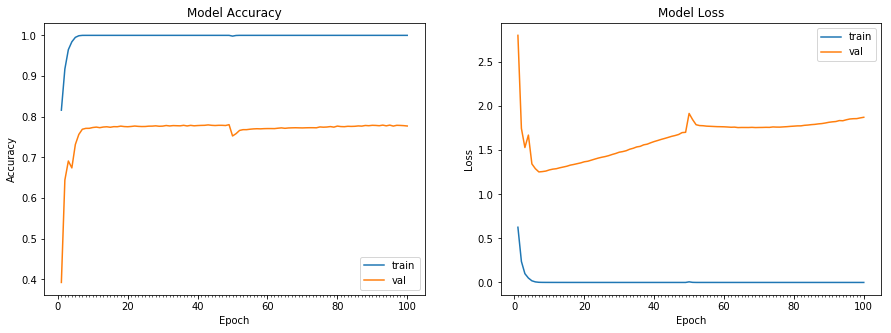

Accuracy on test DATA  is : 77.72


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
datagen = ImageDataGenerator(zoom_range = 0.0, horizontal_flip = False)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

#train model 
start = time.time()

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                samples_per_epoch = train_features.shape[0], nb_epoch = 100,
                                callbacks=[LearningRateScheduler(scheduler, verbose=1)],
                                validation_data = (test_features, test_labels), verbose = 1)
end = time.time()
print("Model took %0.2f second to train"%(end-start))

#Plot Model History
plot_model_history(model_info)

#compute test accuracy 
print("Accuracy on test DATA  is : %0.2f" %accuracy(test_features, test_labels, model))

##Model Score with huge overfitting: need to add Data agumentation/Regularization techniques

In [17]:
score = model.evaluate(test_features, test_labels, verbose=0)
print(score)

[1.8741759154319764, 0.7772]
